In [8]:
from qiskit import transpile
from qiskit import QuantumCircuit
from qiskit.quantum_info import Statevector
from ucc.aqc.mps_sequential import Sequential

import numpy as np
import matplotlib.pyplot as plt
import tqdm

## Approximate State Preparation using MPS Sequential Encoding

Author: Amir Ali Malekani Nezhad (Qualition)

State Preparation is the task of compiling a quantum statevector $\ket{\psi}$ to a quantum circuit. There have been many approaches proposed by Shende, Mottonen, Perciano, Ran, Rudolph, et al who have proposed different schema for tackling this problem. Additionally, some like Pollmann et al have focused on specific types of states which made their algorithm a better fit compared to current state-of-the-art.

This topic has been researched since the early 2000s, and the summary of which is presented below:
- **Exact encoding of arbitrary statevectors:** Amplitude encoding was proposed as the most efficient exact encoding approach to compile arbitrary statevectors. These approaches primarily developed by Shende [[1]] and Mottonen [[2]] and Iten et al [[3]] focus on encoding a vector of $2^N$ elements over a quantum circuit with $N$ qubits and a depth of $2^N$ approximately. Such an approach as inferred from quantum information theory proved that we require an exponential number of gates to encode such an exponential data structure. Whilst these approaches are actively used in most modern packages they still bottleneck the implementation of practical quantum algorithms using this subroutine on actual hardware.
- **Variational encoding of arbitrary statevectors:** With the issue present in Amplitude Encoding, during the 2015 to early 2020s many researchers pivoted towards using QML to approximately encode statevectors. This approach differed significantly from that of Amplitude encoding as it was stochastic (no analytical decomposition like Amplitude encoding), and focused on an iterative approach to gradually train a QNN to fit to the target state's distribution [[4]]. These approaches also had their own challenges, i.e., "orthogonality catastrophe". Orthogonality catastrophe in quantum machine learning refers to a situation where a small change in the parameters of a quantum model causes the quantum state to change drastically, becoming almost completely different (orthogonal) from the original state. This causes an exponential decay in the fidelity measure as the size of the system (number of qubits) increases. This caused more focus on the expressivity of the ansatzes proposed, and the training approach to avoid Barren Plateaus.
- **MPS encoding:** First seen in 2008 [[5]] and becoming prominently known with Ran's work in 2019 [[6]], MPS became a massive success in approximate compilation of statevectors. The approach utilized MPS representation of dense tensors (aka the statevector) to reduce the number of parameters needed to represent the tensor from $2^N$ to $2N\chi^2$ where $\chi$ is called the bond dimension and serves as a hyperparameter controlling the fidelity of the encoding. Given a constant and modest bond dimension as we increase $N$, we in fact reduce the scaling from $O(2^N)$ to $O(N)$. This allowed the limitation imposed by exact encoding to be relaxed to $O(N)$ and provided a significant reduction in depth. However, even MPS approach yet again had challenges. MPS tackles entanglement in a 1D manner, meaning long-range entanglement (if q0 and qN are entangled, this is long-range, whereas q0 and q1 entangled would be considered short-range) had to be captured via deeper circuits. Additionally, Ran's approach required many layers to adequately encode certain types of states, and is known for being very slow to converge. To tackle this, Rudolph et al [[7]] published a work in 2022 which utilized Environment Tensor Updates to optimize the circuit produced by Ran and find the optimal parameters for the circuit without changing depth. This solved the issue with Ran, and is considered state-of-the-art as of writing this notebook.

We can see there have been many different approaches to tackle this problem, each solving some problems and introducing new ones, and in pursuing perfection we have come a long long way from early 2000s works.

[1]: https://arxiv.org/abs/quant-ph/0406176
[2]: https://arxiv.org/abs/quant-ph/0407010
[3]: https://arxiv.org/abs/1501.06911
[4]: https://arxiv.org/abs/1612.02806
[5]: https://arxiv.org/abs/2008.10322
[6]: https://arxiv.org/abs/1908.07958
[7]: https://arxiv.org/abs/2209.00595

### Ran's approach

In simple terms, Ran's approach constructs an MPS from the statevector we want to compile. To exactly encode the MPS we don't need more than one layer, however, we would need $\lceil log_2(\chi) \rceil + 1$ qubits for the tensors depending on their bond dimension. This leads to larger circuits and makes it harder to transfer the circuits to hardware.

He proposed to truncate the bond dimension of the MPS to 2, and encode the truncated version to a circuit which would now only require 1 and 2 qubit gates. This approximately encodes the MPS. To improve the fidelity, we need to generate many layers. Below is the pseudocode borrowed from Rudolph et al. Ran generates a layer, applies its inverse to the original MPS to "update" it or more accurately disentangle it (push it closer to product state $\ket{00 \cdots 0}$), and generates a new layer from the updated original MPS. We do so until we run out of layers, or reach close enough to product state.

Thus, an approximate encoding using an iterative disentangling approach.

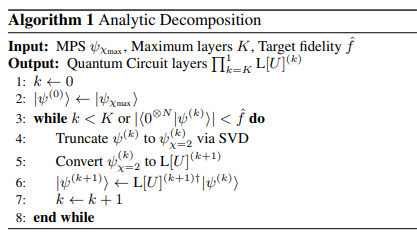

### Lossy Circuit Compression using MPS

In this notebook, we demonstrate how using the linearly scaling MPS encoding as a circuit compression algorithm can reduce the cost of implementation on real-hardware. For the sake of pure comparison and brevity, we will limit the scope of the analysis to vanilla Sequential encoding, that is no environment tensor updates nor use of QML. We will benchmark the raw performance on two cases, **Volume-law entangled states** and **Area-law entangled states**. MPS encoding works great when you use area-law encoding, and struggles with volume-law as tensor networks have a hard time approximating pathological highly entangled states using low rank approximations. With that being said, we will present the performance for both best case and worst case scenarios, and provide an analytics tool to assess when you should use MPS encoding, and when you would be better off with exact encoding.

It is again worth noting that this is the performance of vanilla MPS encoding, and there are indeed ways to circumvent the volume-law entangled issue which is out of the scope of this notebook for the moment. Below are the states:

- **Random Clifford Circuits**: A randomly generated circuit using ["cx", "cz", "cy", "swap", "x", "y", "z", "s", "sdg", "h"] gates. This circuit often exhibits long-range entanglement with volume-law entanglement entropy, making it a perfect candidate for worst case scenario.
- **Random statevectors**: A randomly generated statevector, which can be short-range or long-range entangled BUT will possess area-law entanglement entropy, making it a perfect case for general assessment of MPS in its intended environment.


In [2]:
def random_clifford_circuit(num_qubits, seed=12345):
    """Generate a random clifford circuit
    Parameters:
        num_qubits (int): Number of qubits
        seed (int): Optional. Seed the random number generator, default=12345

    Returns:
        QuantumCircuit: Clifford circuit
    """
    # This code is used to generate the QASM file
    from qiskit.circuit.random import random_clifford_circuit

    gates = ["cx", "cz", "cy", "swap", "x", "y", "z", "s", "sdg", "h"]
    qc = random_clifford_circuit(
        num_qubits,
        gates=gates,
        num_gates=10 * num_qubits * num_qubits,
        seed=seed,
    )
    return qc

In [3]:
def generate_random_statevector(num_qubits, seed=12345):
    """Generate a random statevector
    Parameters:
        num_qubits (int): Number of qubits
        seed (int): Optional. Seed the random number generator, default=12345

    Returns:
        vec (NDArray[np.complex128]): Random statevector
    """
    rng = np.random.default_rng(seed=seed)
    vec = rng.random(2**num_qubits) + 1j * rng.random(2**num_qubits)
    vec /= np.linalg.norm(vec)
    return vec

Benchmark starts from here.

In [10]:
qubits = range(5, 15)
basis_gates = ["cx", "u3"]
sequential = Sequential(0.95)
verbose = False

### Area-law entangled states

In [11]:
area_bench_depths = []
area_bench_cx_counts = []
area_mps_fidelities = []
area_mps_depths = []
area_mps_cx_counts = []

for n in tqdm.tqdm(qubits, desc="Benchmarking MPS with area-law entangled states"):
    target_sv = generate_random_statevector(n)
    bench_qc = QuantumCircuit(n)
    bench_qc.initialize(target_sv, range(n))
    bench_qc = transpile(bench_qc, basis_gates=basis_gates, optimization_level=3)
    bench_depth = bench_qc.depth()
    bench_cx_count = bench_qc.count_ops().get("cx", 0)
    area_bench_depths.append(bench_depth)
    area_bench_cx_counts.append(bench_cx_count)

    # Test the Sequential AQC
    if n < 10:
        num_layers = 5
    elif n < 15:
        num_layers = 10
    else:
        num_layers = 15

    mps_qc = sequential(target_sv, max_num_layers=num_layers, chi_max=2**n)
    mps_qc = transpile(mps_qc, optimization_level=3, basis_gates=basis_gates)
    mps_depth = mps_qc.depth()
    mps_cx_count = mps_qc.count_ops().get('cx', 0) # type: ignore
    area_mps_depths.append(mps_depth)
    area_mps_cx_counts.append(mps_cx_count)

    target_sv_mps = Statevector(mps_qc).data
    area_mps_fidelities.append(np.abs(np.vdot(target_sv, target_sv_mps)))

    if verbose:
        print(f"Random Clifford Circuit with {n} qubits:")
        print(f"Depth: {bench_depth}, Num CX: {bench_cx_count}\n")
        print(f"Sequential AQC Circuit with {n} qubits:")
        print(f"Depth: {mps_depth}, Num CX: {mps_cx_count}")
        print(f"Fidelity: {np.abs(np.vdot(target_sv, target_sv_mps)):.4f}\n")

Benchmarking MPS with area-law entangled states: 100%|██████████| 10/10 [00:58<00:00,  5.84s/it]


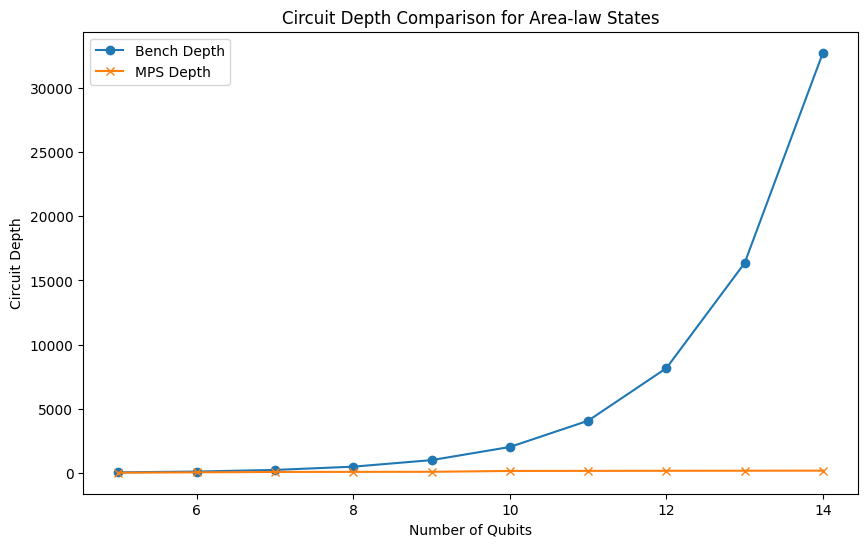

In [12]:
plt.figure(figsize=(10, 6))
plt.plot(qubits, area_bench_depths, label="Bench Depth", marker='o')
plt.plot(qubits, area_mps_depths, label="MPS Depth", marker='x')
plt.xlabel("Number of Qubits")
plt.ylabel("Circuit Depth")
plt.title("Circuit Depth Comparison for Area-law States")
plt.legend()

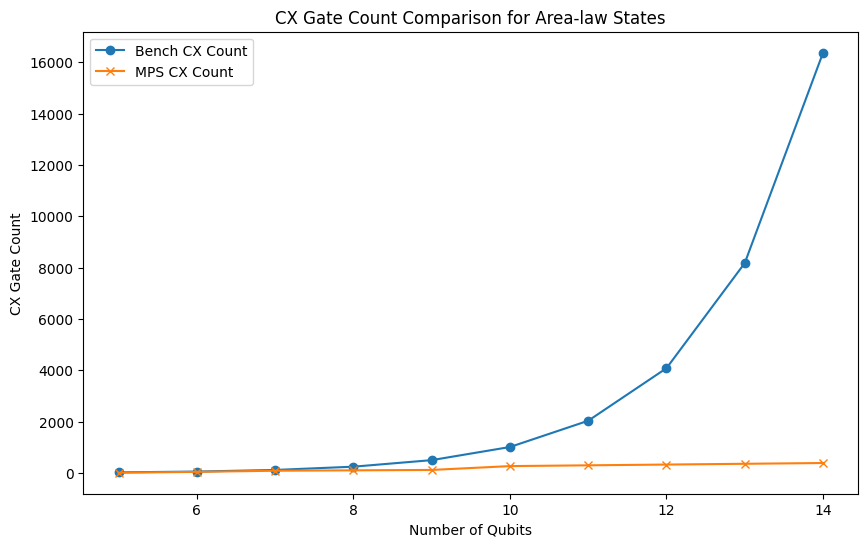

In [13]:
plt.figure(figsize=(10, 6))
plt.plot(qubits, area_bench_cx_counts, label="Bench CX Count", marker='o')
plt.plot(qubits, area_mps_cx_counts, label="MPS CX Count", marker='x')
plt.xlabel("Number of Qubits")
plt.ylabel("CX Gate Count")
plt.title("CX Gate Count Comparison for Area-law States")
plt.legend()

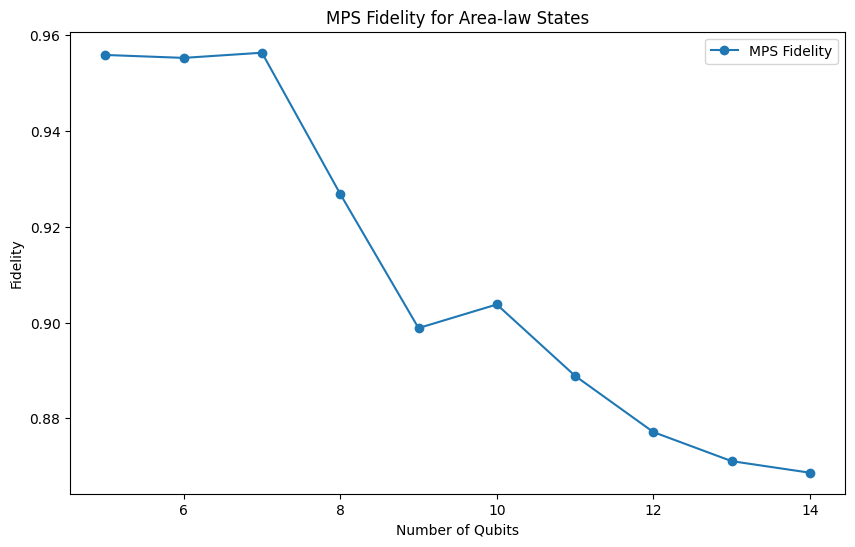

In [14]:
plt.figure(figsize=(10, 6))
plt.plot(qubits, area_mps_fidelities, label="MPS Fidelity", marker='o')
plt.xlabel("Number of Qubits")
plt.ylabel("Fidelity")
plt.title("MPS Fidelity for Area-law States")
plt.legend()

### Volume-law entangled states

In [15]:
volume_bench_depths = []
volume_bench_cx_counts = []
volume_mps_fidelities = []
volume_mps_depths = []
volume_mps_cx_counts = []

for n in tqdm.tqdm(qubits, desc="Benchmarking random Clifford circuits"):
    bench_qc = random_clifford_circuit(n)
    bench_qc = transpile(bench_qc, optimization_level=3, basis_gates=basis_gates)
    bench_depth = bench_qc.depth()
    bench_cx_count = bench_qc.count_ops().get('cx', 0) # type: ignore
    volume_bench_depths.append(bench_depth)
    volume_bench_cx_counts.append(bench_cx_count)

    target_sv = Statevector(bench_qc).data

    # Test the Sequential AQC
    if n < 10:
        num_layers = 5
    elif n < 15:
        num_layers = 10
    else:
        num_layers = 15

    mps_qc = sequential(target_sv, max_num_layers=num_layers, chi_max=2**n)
    mps_qc = transpile(mps_qc, optimization_level=3, basis_gates=basis_gates)
    mps_depth = mps_qc.depth()
    mps_cx_count = mps_qc.count_ops().get('cx', 0) # type: ignore
    volume_mps_depths.append(mps_depth)
    volume_mps_cx_counts.append(mps_cx_count)
    target_sv_mps = Statevector(mps_qc).data
    volume_mps_fidelities.append(np.abs(np.vdot(target_sv, target_sv_mps)))

    if verbose:
        print(f"Random Clifford Circuit with {n} qubits:")
        print(f"Depth: {bench_depth}, Num CX: {bench_cx_count}\n")
        print(f"Sequential AQC Circuit with {n} qubits:")
        print(f"Depth: {mps_depth}, Num CX: {mps_cx_count}")
        print(f"Fidelity: {np.abs(np.vdot(target_sv, target_sv_mps)):.4f}\n")

Benchmarking random Clifford circuits: 100%|██████████| 10/10 [00:11<00:00,  1.12s/it]


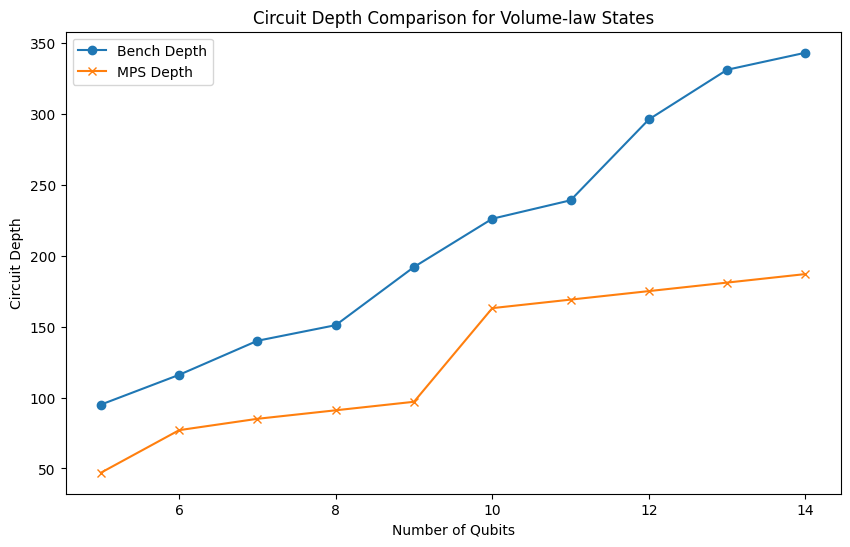

In [16]:
plt.figure(figsize=(10, 6))
plt.plot(qubits, volume_bench_depths, label="Bench Depth", marker='o')
plt.plot(qubits, volume_mps_depths, label="MPS Depth", marker='x')
plt.xlabel("Number of Qubits")
plt.ylabel("Circuit Depth")
plt.title("Circuit Depth Comparison for Volume-law States")
plt.legend()
plt.show()

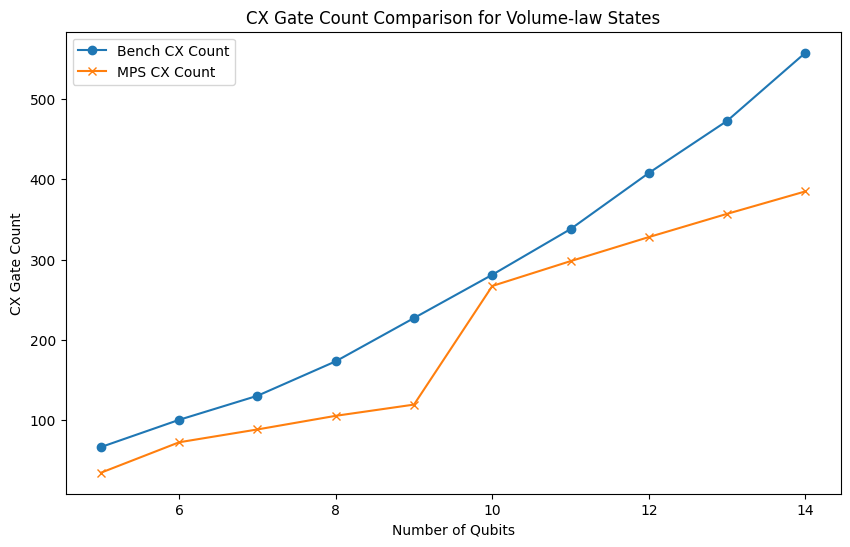

In [17]:
plt.figure(figsize=(10, 6))
plt.plot(qubits, volume_bench_cx_counts, label="Bench CX Count", marker='o')
plt.plot(qubits, volume_mps_cx_counts, label="MPS CX Count", marker='x')
plt.xlabel("Number of Qubits")
plt.ylabel("CX Gate Count")
plt.title("CX Gate Count Comparison for Volume-law States")
plt.legend()
plt.show()

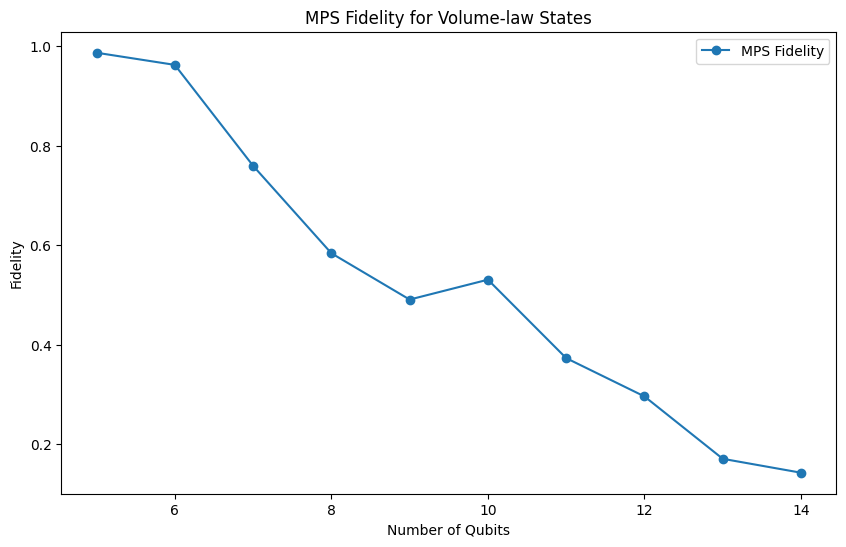

In [18]:
plt.figure(figsize=(10, 6))
plt.plot(qubits, volume_mps_fidelities, label="MPS Fidelity", marker='o')
plt.xlabel("Number of Qubits")
plt.ylabel("Fidelity")
plt.title("MPS Fidelity for Volume-law States")
plt.legend()
plt.show()

### Comparison

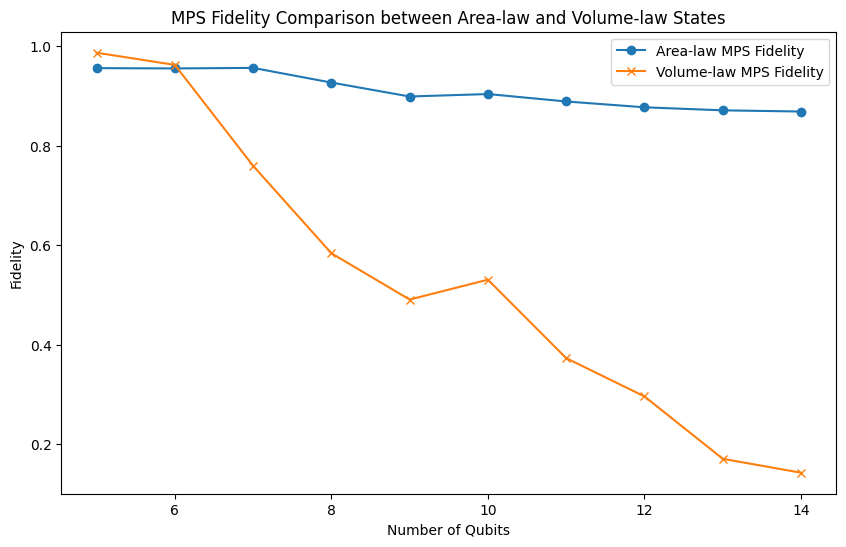

In [19]:
plt.figure(figsize=(10, 6))
plt.plot(qubits, area_mps_fidelities, label="Area-law MPS Fidelity", marker='o')
plt.plot(qubits, volume_mps_fidelities, label="Volume-law MPS Fidelity", marker='x')
plt.xlabel("Number of Qubits")
plt.ylabel("Fidelity")
plt.title("MPS Fidelity Comparison between Area-law and Volume-law States")
plt.legend()
plt.show()

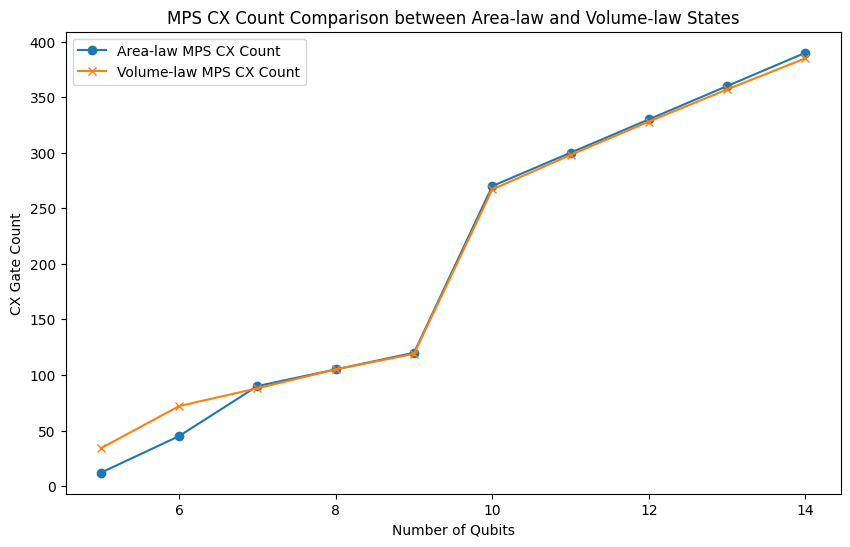

In [20]:
plt.figure(figsize=(10, 6))
plt.plot(qubits, area_mps_cx_counts, label="Area-law MPS CX Count", marker='o')
plt.plot(qubits, volume_mps_cx_counts, label="Volume-law MPS CX Count", marker='x')
plt.xlabel("Number of Qubits")
plt.ylabel("CX Gate Count")
plt.title("MPS CX Count Comparison between Area-law and Volume-law States")
plt.legend()
plt.show()

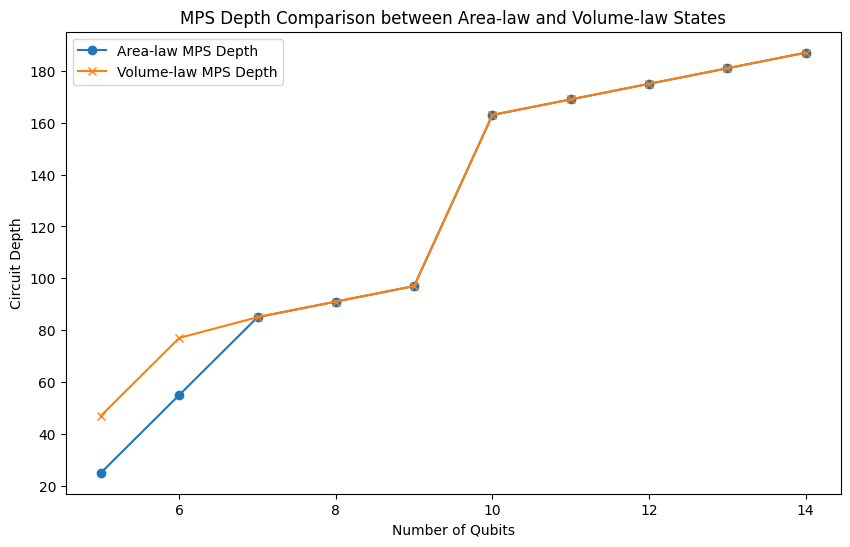

In [21]:
plt.figure(figsize=(10, 6))
plt.plot(qubits, area_mps_depths, label="Area-law MPS Depth", marker='o')
plt.plot(qubits, volume_mps_depths, label="Volume-law MPS Depth", marker='x')
plt.xlabel("Number of Qubits")
plt.ylabel("Circuit Depth")
plt.title("MPS Depth Comparison between Area-law and Volume-law States")
plt.legend()
plt.show()

### Summary

We can see that whilst the CX count and circuit depth is approximately equal between the area-law and volume-law states, the fidelity differs significantly. This is due to the difficulty and often the infeasibility of approximating the complex entanglement of volume-law states with low-rank tensors.

Ran's approach by itself is a great approximate circuit compiler when used properly, that is with area-law entangled states and from our observation plateaus around 0.87. This approach expectedly perform horribly for volume-law and thus requires certain modifications to bring a consistent fidelity regardless of state. One such modification is using environment tensor updates. This feature is implemented in `qmprs` and you can optionally try it out below.

Disclaimer note: `qmprs` is built with `quick` and can be a bit heavy in terms of dependency size.

In [ ]:
!pip install git+https://github.com/Qualition/qmprs.git

### `qmprs` with Area-law states

In [42]:
import tqdm

from qmprs.synthesis.mps_encoding import Sequential
from quick.circuit import QiskitCircuit

qmprs_sequential = Sequential(QiskitCircuit)

area_bench_depths = []
area_bench_cx_counts = []
area_qmprs_fidelities = []
area_qmprs_depths = []
area_qmprs_cx_counts = []

for n in tqdm.tqdm(qubits, desc="Benchmarking area-law entangled states with qmprs"):
    target_sv = generate_random_statevector(n)
    bench_qc = QuantumCircuit(n)
    bench_qc.initialize(target_sv, range(n))
    bench_qc = transpile(bench_qc, basis_gates=basis_gates, optimization_level=3)
    bench_depth = bench_qc.depth()
    bench_cx_count = bench_qc.count_ops().get('cx', 0) # type: ignore
    area_bench_depths.append(bench_depth)
    area_bench_cx_counts.append(bench_cx_count)

    # Test the Qmprs Sequential AQC
    if n < 7:
        num_layers = 3
    elif n < 10:
        num_layers = 5
    elif n < 15:
        num_layers = 7
    else:
        num_layers = 10

    mps_qc = qmprs_sequential.prepare_state(
        target_sv, bond_dimension=2**n, num_layers=num_layers, num_sweeps=10*n
    )
    mps_depth = mps_qc.get_depth()
    mps_cx_count = mps_qc.count_ops().get('CX', 0) # type: ignore
    target_sv_mps = mps_qc.get_statevector()
    fidelity = np.abs(np.vdot(target_sv, target_sv_mps))
    area_qmprs_depths.append(mps_depth)
    area_qmprs_cx_counts.append(mps_cx_count)
    area_qmprs_fidelities.append(fidelity)

    if verbose:
        print(f"Random Clifford Circuit with {n} qubits:")
        print(f"Depth: {bench_depth}, Num CX: {bench_cx_count}\n")
        print(f"Qmprs Sequential AQC Circuit with {n} qubits:")
        print(f"Depth: {mps_depth}, Num CX: {mps_cx_count}")
        print(f"Fidelity: {fidelity:.4f}\n")

Benchmarking area-law entangled states with qmprs: 100%|██████████| 10/10 [02:17<00:00, 13.74s/it]


In [43]:
import tqdm

from qmprs.synthesis.mps_encoding import Sequential
from quick.circuit import QiskitCircuit

qmprs_sequential = Sequential(QiskitCircuit)

volume_bench_depths = []
volume_bench_cx_counts = []
volume_qmprs_fidelities = []
volume_qmprs_depths = []
volume_qmprs_cx_counts = []

for n in tqdm.tqdm(qubits, desc="Benchmarking random clifford circuits with qmprs"):
    bench_qc = random_clifford_circuit(n)
    bench_qc = transpile(bench_qc, basis_gates=basis_gates, optimization_level=3)
    bench_depth = bench_qc.depth()
    bench_cx_count = bench_qc.count_ops().get('cx', 0) # type: ignore
    volume_bench_depths.append(bench_depth)
    volume_bench_cx_counts.append(bench_cx_count)

    target_sv = Statevector(bench_qc).data

    # Test the Qmprs Sequential AQC
    if n < 7:
        num_layers = 3
    elif n < 10:
        num_layers = 5
    elif n < 15:
        num_layers = 7
    else:
        num_layers = 10

    mps_qc = qmprs_sequential.prepare_state(
        target_sv, bond_dimension=2**n, num_layers=num_layers, num_sweeps=10*n
    )
    mps_depth = mps_qc.get_depth()
    mps_cx_count = mps_qc.count_ops().get('CX', 0) # type: ignore
    target_sv_mps = mps_qc.get_statevector()
    fidelity = np.abs(np.vdot(target_sv, target_sv_mps))
    volume_qmprs_depths.append(mps_depth)
    volume_qmprs_cx_counts.append(mps_cx_count)
    volume_qmprs_fidelities.append(fidelity)

    if verbose:
        print(f"Random Clifford Circuit with {n} qubits:")
        print(f"Depth: {bench_depth}, Num CX: {bench_cx_count}\n")
        print(f"Qmprs Sequential AQC Circuit with {n} qubits:")
        print(f"Depth: {mps_depth}, Num CX: {mps_cx_count}")
        print(f"Fidelity: {fidelity:.4f}\n")

Benchmarking random clifford circuits with qmprs: 100%|██████████| 10/10 [01:24<00:00,  8.49s/it]


### Comparison

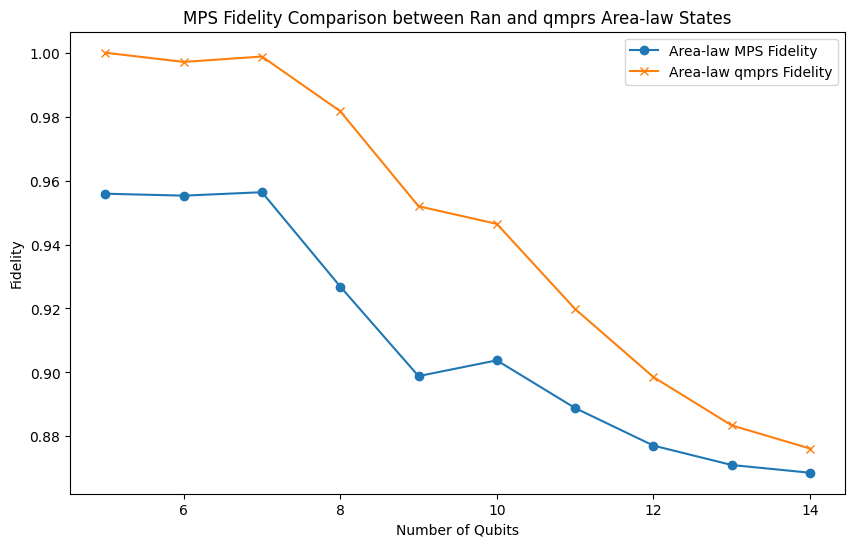

In [44]:
plt.figure(figsize=(10, 6))
plt.plot(qubits, area_mps_fidelities, label="Area-law MPS Fidelity", marker='o')
plt.plot(qubits, area_qmprs_fidelities, label="Area-law qmprs Fidelity", marker='x')
plt.xlabel("Number of Qubits")
plt.ylabel("Fidelity")
plt.title("MPS Fidelity Comparison between Ran and qmprs Area-law States")
plt.legend()
plt.show()

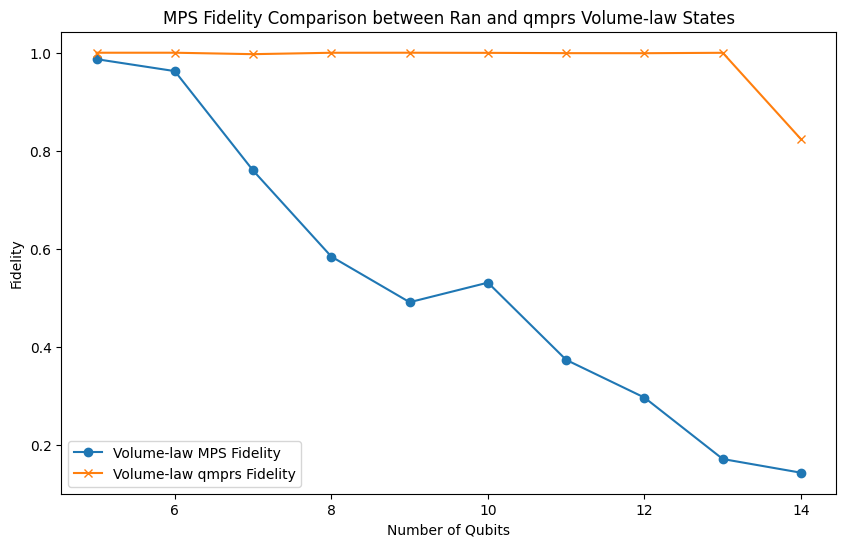

In [45]:
plt.figure(figsize=(10, 6))
plt.plot(qubits, volume_mps_fidelities, label="Volume-law MPS Fidelity", marker='o')
plt.plot(qubits, volume_qmprs_fidelities, label="Volume-law qmprs Fidelity", marker='x')
plt.xlabel("Number of Qubits")
plt.ylabel("Fidelity")
plt.title("MPS Fidelity Comparison between Ran and qmprs Volume-law States")
plt.legend()
plt.show()

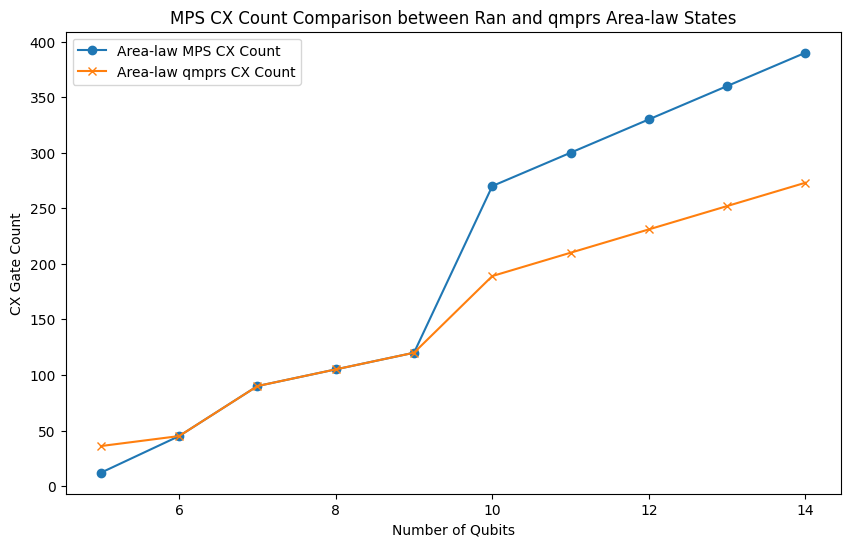

In [46]:
plt.figure(figsize=(10, 6))
plt.plot(qubits, area_mps_cx_counts, label="Area-law MPS CX Count", marker='o')
plt.plot(qubits, area_qmprs_cx_counts, label="Area-law qmprs CX Count", marker='x')
plt.xlabel("Number of Qubits")
plt.ylabel("CX Gate Count")
plt.title("MPS CX Count Comparison between Ran and qmprs Area-law States")
plt.legend()
plt.show()

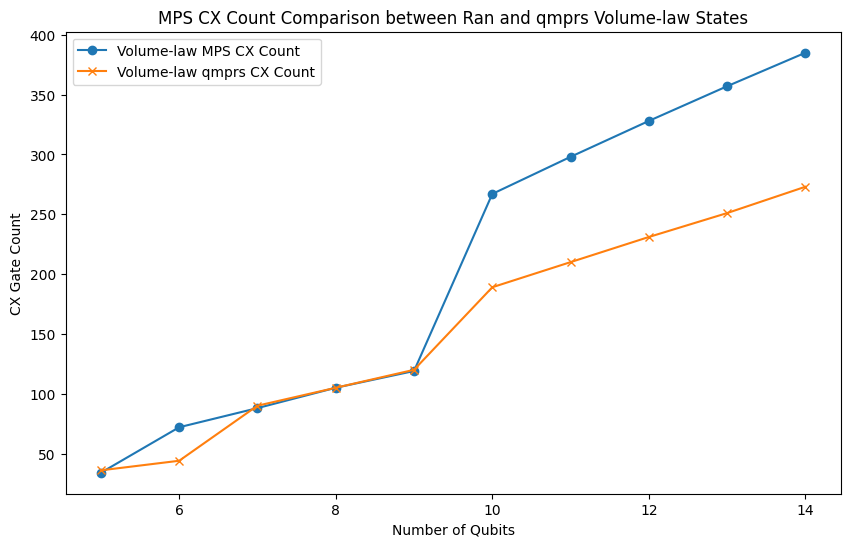

In [47]:
plt.figure(figsize=(10, 6))
plt.plot(qubits, volume_mps_cx_counts, label="Volume-law MPS CX Count", marker='o')
plt.plot(qubits, volume_qmprs_cx_counts, label="Volume-law qmprs CX Count", marker='x')
plt.xlabel("Number of Qubits")
plt.ylabel("CX Gate Count")
plt.title("MPS CX Count Comparison between Ran and qmprs Volume-law States")
plt.legend()
plt.show()

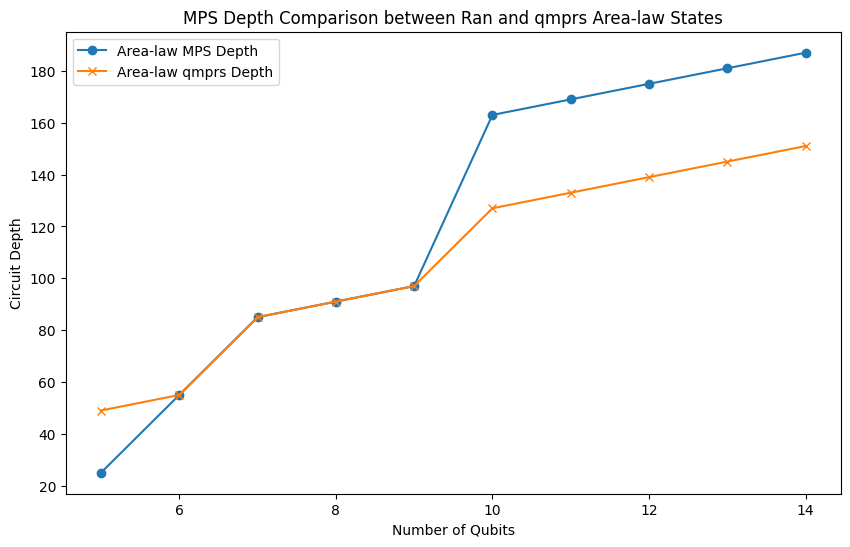

In [48]:
plt.figure(figsize=(10, 6))
plt.plot(qubits, area_mps_depths, label="Area-law MPS Depth", marker='o')
plt.plot(qubits, area_qmprs_depths, label="Area-law qmprs Depth", marker='x')
plt.xlabel("Number of Qubits")
plt.ylabel("Circuit Depth")
plt.title("MPS Depth Comparison between Ran and qmprs Area-law States")
plt.legend()
plt.show()

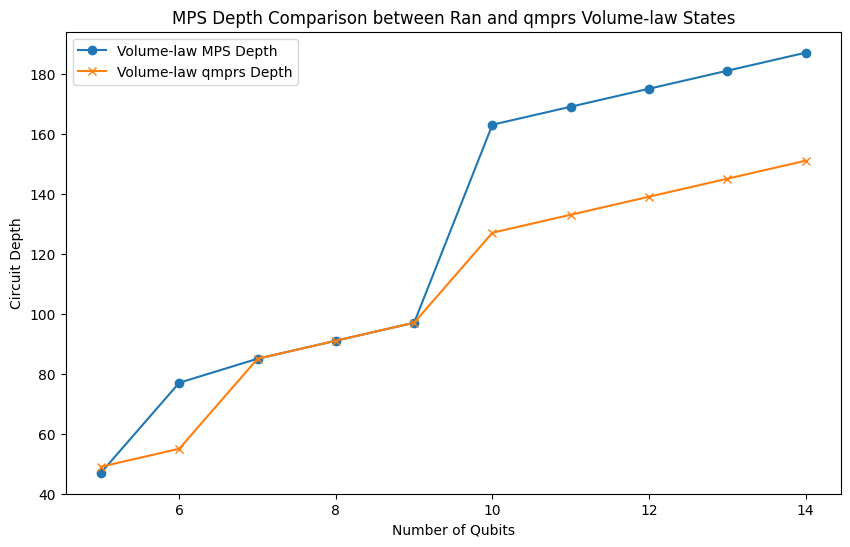

In [49]:
plt.figure(figsize=(10, 6))
plt.plot(qubits, volume_mps_depths, label="Volume-law MPS Depth", marker='o')
plt.plot(qubits, volume_qmprs_depths, label="Volume-law qmprs Depth", marker='x')
plt.xlabel("Number of Qubits")
plt.ylabel("Circuit Depth")
plt.title("MPS Depth Comparison between Ran and qmprs Volume-law States")
plt.legend()
plt.show()

### How to tell if a state is area-law entangled or volume-law entangled?

In simple terms, we look at how the entanglement entropy grows with the increase of the subsystem we are checking. If it's a straight line, it's volume law entangled. If it's a curved line that slowly decays, it's area law entangled. MPS performs best for area-law entangled states.

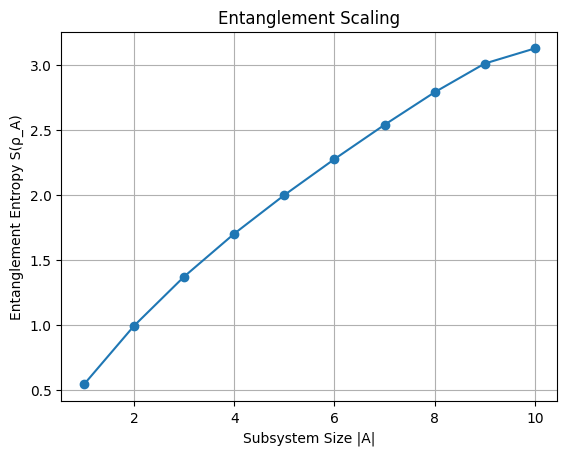

In [50]:
import numpy as np
import matplotlib.pyplot as plt
from qiskit.quantum_info import partial_trace, entropy

# psi: statevector of n qubits
n = 20
psi =  np.random.rand(2**n) + 1j * np.random.rand(2**n)
psi /= np.linalg.norm(psi)  # Normalize the statevector

entropies = []
for k in range(1, n//2 + 1):
    # Trace out rest of the qubits
    rho_A = partial_trace(psi, list(range(k, n)))
    S = entropy(rho_A, base=2)
    entropies.append(S)

plt.plot(range(1, n//2 + 1), entropies, marker='o')
plt.xlabel('Subsystem Size |A|')
plt.ylabel('Entanglement Entropy S(ρ_A)')
plt.title('Entanglement Scaling')
plt.grid(True)
plt.show()

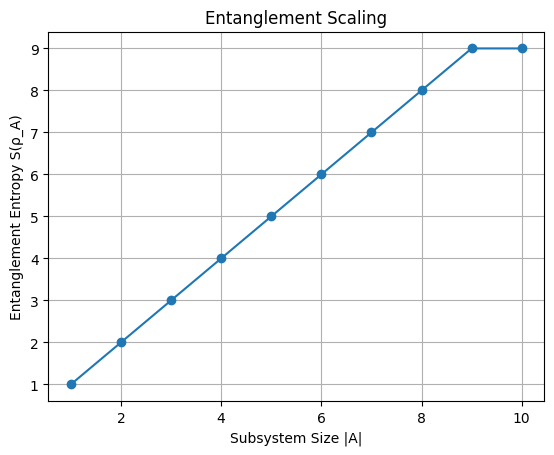

In [51]:
import matplotlib.pyplot as plt
from qiskit.quantum_info import Statevector, partial_trace, entropy

# psi: statevector of n qubits
n = 20
psi =  Statevector(random_clifford_circuit(n)).data

entropies = []
for k in range(1, n//2 + 1):
    rho_A = partial_trace(psi, list(range(k, n)))  # Trace out rest
    S = entropy(rho_A, base=2)
    entropies.append(S)

plt.plot(range(1, n//2 + 1), entropies, marker='o')
plt.xlabel('Subsystem Size |A|')
plt.ylabel('Entanglement Entropy S(ρ_A)')
plt.title('Entanglement Scaling')
plt.grid(True)
plt.show()

Also, do note the difference between maximum entanglement entropy. The higher it is, the more layers we need to peel it away, and thus deeper circuits.